Recently, I've come to realize how powerful the convolution operation can be. This notebook is an exploration of image convolution to draw Kanjis.

# Introduction to image convolution using matplotlib 

Convolution is basically the application of a moving signal to an existing signal. Interestingly, this is exactly what we are dowing when we are writing: we move a pen over an imaginary trajectory. Let's try to do illustrate this with a simple example.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np

First we draw an ellipse.

In [2]:
angle = -30

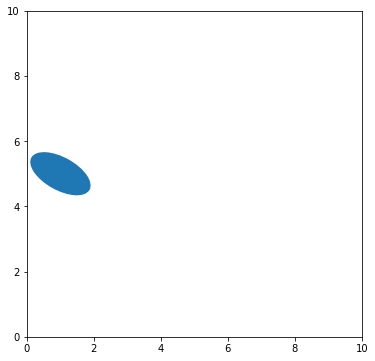

In [3]:
plt.figure(figsize=(6, 6))
plt.xlim(0, 10)
plt.ylim(0, 10)
ellipse = Ellipse((1, 5), 2, 1, angle=angle)
plt.gca().add_artist(ellipse)

But now, let's imagine the ellipse is following a wiggly line.

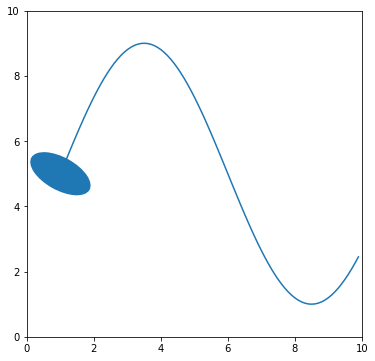

In [4]:
plt.figure(figsize=(6, 6))
plt.xlim(0, 10)
plt.ylim(0, 10)
ellipse = Ellipse((1, 5), 2, 1, angle=angle)
plt.gca().add_artist(ellipse)
x = np.arange(1, 10, 0.1)
y = 4 * np.sin(2 * np.pi * (x - x.min()) / 10) + 5
plt.plot(x, y)

We can actually draw a lot of ellipses on top of the line to see what effect this yields. 

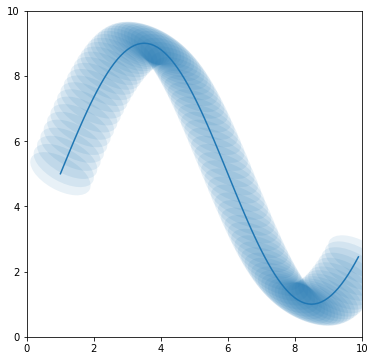

In [5]:
plt.figure(figsize=(6, 6))
plt.xlim(0, 10)
plt.ylim(0, 10)
x = np.arange(1, 10, 0.1)
y = 4 * np.sin(2 * np.pi * (x - x.min()) / 10) + 5
plt.plot(x, y)
for xx, yy in zip(x, y):
    ellipse = Ellipse((xx, yy), 2, 1, angle=angle, alpha=0.1)
    plt.gca().add_artist(ellipse)

That's it, we are drawing! However, one of the problems we have if we do the drawing like this is that we have to use matplotlib as our drawing backend. It turns out we can do the same operation in a slightly different way without using matplotlib.

# Image convolution using raster grids

Another way of thinking about this drawing is to have two images: one represents the trajectory of the pen (our line) and the over the pattern to be drawn. It turns out a 2D convolution can apply the pattern on top of the trajectory.

Let's first build a trajectory image. To do this, we create an empty image:

In [6]:
n = 128

In [7]:
trajectory = np.zeros((n, n))

We use grid coordinates to rasterize the line (project it to a grid):

In [8]:
X, Y = np.meshgrid(np.linspace(0, 10, n), np.linspace(0, 10, n))

In [9]:
for xx, yy in zip(x, y):
    j = np.abs(X-xx).argmin() 
    i = np.abs(Y[:, j] - yy).argmin()
    trajectory[i, j] = 1

Let's look at the result:

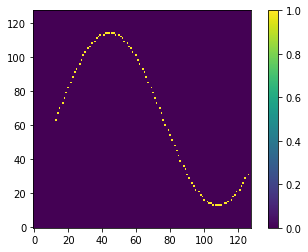

In [10]:
plt.imshow(trajectory, origin='lower')
plt.colorbar()

Now, let's make a pattern image. We will center the pattern we want to apply. First, let's build rotated coordinate matrices.

In [11]:
X, Y = np.meshgrid(np.linspace(0, 10, n) - 5, np.linspace(0, 10, n) - 5)

In [12]:
Xp = np.cos(np.deg2rad(angle)) * X + np.sin(np.deg2rad(angle)) * Y
Yp = -np.sin(np.deg2rad(angle)) * X + np.cos(np.deg2rad(angle)) * Y

Next, let's define our pattern and plot it:

In [13]:
pattern = Xp**2/2 + Yp**2 < 1

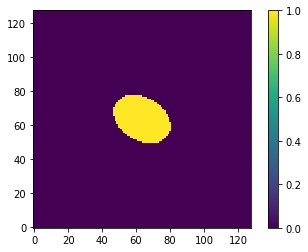

In [14]:
plt.imshow(pattern, origin='lower')
plt.colorbar()

Good, now what we really wand to do is convolve this with our previous matrix.

In [15]:
from scipy.signal import convolve2d

In [16]:
drawing = convolve2d(trajectory, pattern, mode='same')

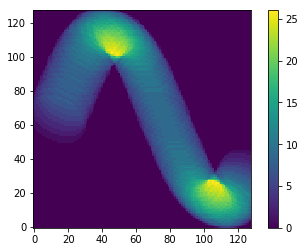

In [17]:
plt.imshow(drawing, origin='lower')
plt.colorbar()

Interestingly, we recover the same shape, but the drawing is not the same. Let's try to threshold this:

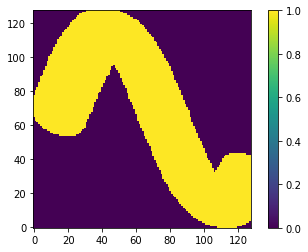

In [18]:
plt.imshow(drawing > 1, origin='lower')
plt.colorbar()

Another way to compute the convolution can be to use `fftconvolve`. Let's see if this works better.

In [19]:
from scipy.signal import fftconvolve

In [20]:
drawing2 = fftconvolve(trajectory, pattern, mode='same')

Is the result close?

In [21]:
np.allclose(drawing, drawing2)

True

Let's look at it.

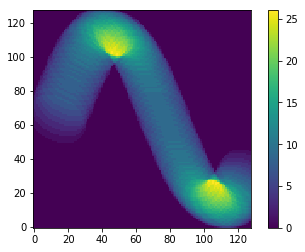

In [22]:
plt.imshow(drawing2, origin='lower')
plt.colorbar()

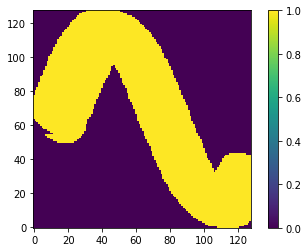

In [23]:
plt.imshow(drawing2 > 1, origin='lower')
plt.colorbar()

Actually, this seems faster than the first convolution. Let's benchmark both of these.

In [24]:
%timeit convolve2d(trajectory, pattern, mode='same')

1 loop, best of 3: 639 ms per loop


In [25]:
%timeit fftconvolve(trajectory, pattern, mode='same')

100 loops, best of 3: 3.97 ms per loop


Indeed, there's nothing to say here, the result is 100 times faster with fftconvolve. Let's move on to our next section.

# Drawing kanjis using kanjivg 

## KanjiVG 

[Kanjivg](http://kanjivg.tagaini.net/index.html) is a way of describing kanji characters using SVG. This means that it is also valid XML that can be parsed easily. Let's start by downloading a character.

In [26]:
import requests

In [65]:
url = 'https://raw.githubusercontent.com/KanjiVG/kanjivg/master/kanji/04ea2-Kaisho.svg'
r = requests.get(url)

The XML looks like this:

In [82]:
r.text

'<?xml version="1.0" encoding="UTF-8"?>\n<!--\nCopyright (C) 2009/2010/2011 Ulrich Apel.\nThis work is distributed under the conditions of the Creative Commons\nAttribution-Share Alike 3.0 Licence. This means you are free:\n* to Share - to copy, distribute and transmit the work\n* to Remix - to adapt the work\n\nUnder the following conditions:\n* Attribution. You must attribute the work by stating your use of KanjiVG in\n  your own copyright header and linking to KanjiVG\'s website\n  (http://kanjivg.tagaini.net)\n* Share Alike. If you alter, transform, or build upon this work, you may\n  distribute the resulting work only under the same or similar license to this\n  one.\n\nSee http://creativecommons.org/licenses/by-sa/3.0/ for more details.\n-->\n<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.0//EN" "http://www.w3.org/TR/2001/REC-SVG-20010904/DTD/svg10.dtd" [\n<!ATTLIST g\nxmlns:kvg CDATA #FIXED "http://kanjivg.tagaini.net"\nkvg:element CDATA #IMPLIED\nkvg:variant CDATA #IMPLIED\nkvg:partia

What it describes is this character:

In [83]:
from IPython.display import SVG

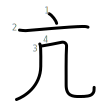

In [84]:
SVG(data=r.text)

We see that there are four strokes in the character. They are described in {http://www.w3.org/2000/svg}path elements. Let's extract them.

In [85]:
import xml.etree.ElementTree as ET

In [86]:
def extract_paths_from_svg(svg_text):
    """Returns all paths in SVG."""
    tree = ET.fromstring(svg_text)
    return  tree.findall('.//{http://www.w3.org/2000/svg}path')

In [87]:
paths = extract_paths_from_svg(r.text)
paths 

[<Element '{http://www.w3.org/2000/svg}path' at 0x00000000154CDF98>,
 <Element '{http://www.w3.org/2000/svg}path' at 0x0000000012D1DD68>,
 <Element '{http://www.w3.org/2000/svg}path' at 0x00000000154000E8>,
 <Element '{http://www.w3.org/2000/svg}path' at 0x0000000015400868>]

In [96]:
paths[0].items()[2]

('d', 'M49.14,13.75c2.82,1.4,6.97,6.84,7.46,9.58')

For each of these elements, the path is described as a succession of movements in the [path data](https://www.w3.org/TR/SVG/paths.html#PathData).

> The M (absolute) or m (relative) indicates a moveto with parameters (x y) that **starts a new sub-path** at the given (x,y) coordinate

> The C (absolute) or c (relative) indicates a curveto with parameters (x1 y1 x2 y2 x y) that **draws a cubic Bézier curve** from the current point to (x,y) using (x1,y1) as the control point at the beginning of the curve and (x2,y2) as the control point at the end of the curve

Let's look at what a path looks like:

We can easily parse the data string to recover the coordinates for the trajectory.

In [72]:
import re

In [99]:
print(re.split('([McC])',  paths[0].items()[2][1]))

['', 'M', '49.14,13.75', 'c', '2.82,1.4,6.97,6.84,7.46,9.58']


This means that the path starts at coordinates 49.14, 13.75 and then continues with a Bézier curve.

## Bézier curves 

Bézier curves are an interesting way of describing parametric curves. As we have seen in the previous section, the $c$ curve-to command in SVG uses cubic Bézier curves.

[John D. Cook has a good explanation](https://www.johndcook.com/blog/2009/12/21/bezier-basics/) of what they are. The mathematics is simple: we need to define three points $\vec{Pi}$ and then apply the formula below to every $t \in [0, 1]$ to have a curve.

$$
B(t) = (1-t)^3 \cdot \vec{P0} + 3(1-t)^2 t \cdot \vec{P1} + 3(1-t)t^2 \cdot \vec{P2} + t^3 \cdot \vec{P3}
$$

Let's write a Bézier curve maker.

In [100]:
def make_bezier_func(points):
    "Creates a Bézier function."
    return lambda t: (1 - t)**3 * points[0] + \
                    3 * (1 - t)**2 * t * points[1] + \
                    3 * (1 - t) * t**2 * points[2] + \
                    t**3 * points[3]

Let's test this.

In [101]:
points = np.array([[1, 1],
                   [1, 2],
                   [2, 3],
                   [2, 1]])
bz = make_bezier_func(points)

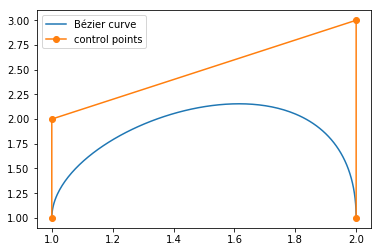

In [102]:
t = np.linspace(0, 1, num=200)[:, np.newaxis]
plt.plot(bz(t)[:, 0], bz(t)[:, 1], label='Bézier curve')
plt.plot(points[:, 0], points[:, 1], '-o', label='control points')
plt.legend()

## Parsing a path into Bézier curves 

Now what we need to do is simply to parse the paths into Bézier curves. We can then chain these and draw them on the screen.

We need a way to convert elements into floating points.

In [103]:
def elem_to_points(elem):
    "Converts a string in SVG jargon to floats."
    elem = elem.strip()
    split_points = re.split(',|(-)', elem)
    points = []
    mult = 1
    for item in [_ for _ in split_points if _ is not None if len(_) > 0 if _ != ' ']:
        if item == '-':
            mult = -1
        else:
            points.append(mult * float(item))
            mult = 1
    return points

In [104]:
elem_to_points("0.18,4.04,0.19,9.72,0.09,17.25")

[0.18, 4.04, 0.19, 9.72, 0.09, 17.25]

In [105]:
elem_to_points("12.19-0.91,42.94-3.91,57.14-4.2")

[12.19, -0.91, 42.94, -3.91, 57.14, -4.2]

In [106]:
elem_to_points(' -0.499127,1.753402 -1.680564,3.26525 -2.608477,4.338626 -3.406509,4.993902 -12.418956,11.713536 -19.605535,15.896692')

[-0.499127,
 1.753402,
 -1.680564,
 3.26525,
 -2.608477,
 4.338626,
 -3.406509,
 4.993902,
 -12.418956,
 11.713536,
 -19.605535,
 15.896692]

And now we can parse the path.

In [107]:
def parse_path(path_data):
    """Parses a path_data from the SVG into a Bézier curve list."""
    curves = []
    re_split = re.split('([McCsS])',  path_data) 
    re_split = [_ for _ in re_split if len(_) > 0]
    for elem, next_elem in zip(re_split[::2], re_split[1::2]):
        if elem == 'M':
            current_point = np.array([float(_) for _ in next_elem.split(',')])
        if elem == 'c':
            points = elem_to_points(next_elem)
            points = np.array(points).reshape((-1, 2))
            points += current_point # since coords are relative
            points = np.vstack((current_point, points))
            bz = make_bezier_func(points)
            curves.append(bz)
            current_point = points[-1, :]
        if elem == 'C':
            points = elem_to_points(next_elem)
            points = np.array(points).reshape((-1, 2))
            points = np.vstack((current_point, points))
            bz = make_bezier_func(points)
            curves.append(bz)
            current_point = points[-1, :]
    return curves

Let's test this on the data.

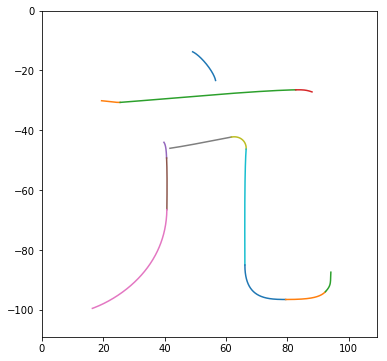

In [110]:
plt.figure(figsize=(6, 6))
for path in paths:
    path_data = path.items()[2][1]
    curves = parse_path(path_data)
    t = np.linspace(0, 1, num=200)[:, np.newaxis]
    for bz in curves:
        plt.plot(bz(t)[:, 0], -bz(t)[:, 1], label='Bézier curve')
    plt.xlim(0, 109)
    plt.ylim(-109, 0)

Nice! It works. We can now convert this to a rasterized form.

## Rasterizing the Bézier curves

Let's now write a function that rasterizes a list of Bézier curves.

In [111]:
def rasterize(curves, n=128):
    """Computes a rasterized image of the Bézier curves."""
    rastered = np.zeros((n, n))
    X, Y = np.meshgrid(np.linspace(0, 109, n), np.linspace(-109, 0, n))
    t = np.linspace(0, 1, num=200)[:, np.newaxis]
    for bz in curves: 
        x, y = bz(t)[:, 0], -bz(t)[:, 1]
        for xx, yy in zip(x, y):
            j = np.abs(X-xx).argmin() 
            i = np.abs(Y[:, j] - yy).argmin()
            rastered[i, j] = 1
    return rastered

In [117]:
all_curves = []
for path in paths:
    path_data = path.items()[2][1]
    curves = parse_path(path_data)
    all_curves.extend(curves)
rastered = rasterize(all_curves)

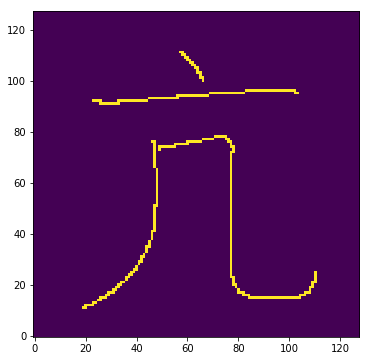

In [118]:
plt.figure(figsize=(6, 6))
plt.imshow(rastered, origin='lower')

## Convolution 

What's left missing is now the convolution.

In [119]:
drawing = fftconvolve(rastered, pattern, mode='same')

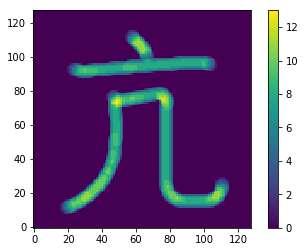

In [120]:
plt.imshow(drawing, origin='lower')
plt.colorbar()

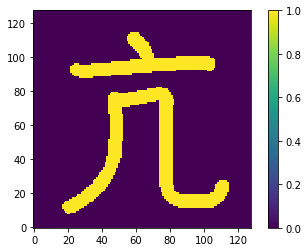

In [122]:
plt.imshow(drawing > 2, origin='lower')
plt.colorbar()

Well this looks interesting. What remains now is to play with the tools and patterns to draw more interesting figures.

# Playing with the kanji signs 

First, let's make a patterning function for the painting sign.

In [123]:
def make_ellipse(n, angle, a, b):
    """Geneartes a rotated ellipse pattern."""
    X, Y = np.meshgrid(np.linspace(0, 10, n) - 5, np.linspace(0, 10, n) - 5)
    Xp = np.cos(np.deg2rad(angle)) * X + np.sin(np.deg2rad(angle)) * Y
    Yp = -np.sin(np.deg2rad(angle)) * X + np.cos(np.deg2rad(angle)) * Y
    pattern = Xp**2/a + Yp**2/b < 1
    return pattern

## Interactive exploration 

We can now generate some patterns and paint them.

In [124]:
from ipywidgets import interact_manual, interact

In [125]:
from skimage.filters import threshold_otsu

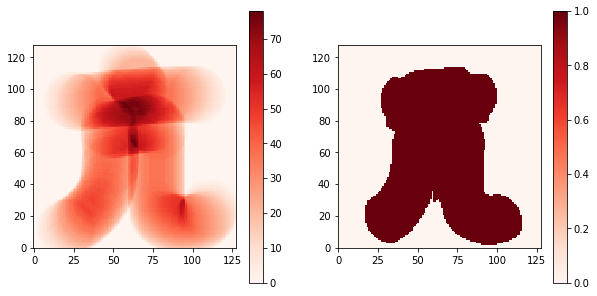

In [126]:
@interact
def paint_kanji(a=(0.1, 4), b=(0.1, 4), 
                angle=(-90, 90)):
    plt.figure(figsize=(10, 5))
    pattern  = make_ellipse(n, angle, a, b)
    drawing = fftconvolve(rastered, pattern, mode='same')
    plt.subplot(121)
    plt.imshow(drawing, origin='lower', cmap='Reds')
    plt.colorbar()
    plt.subplot(122)
    plt.imshow(drawing > threshold_otsu(drawing), origin='lower', cmap='Reds')
    plt.colorbar()

In [128]:
@interact_manual
def paint_kanji():
    angle = np.random.randint(-90, 90)
    a = np.random.rand() * 2
    b = np.random.rand() * 3
    pattern  = make_ellipse(n, angle, a, b)
    drawing = fftconvolve(rastered, pattern, mode='same')
    plt.subplot(121)
    plt.imshow(drawing, origin='lower', cmap='Greys')
    plt.colorbar()
    plt.subplot(122)
    plt.imshow(drawing > threshold_otsu(drawing), origin='lower', cmap='Reds')
    plt.colorbar()

## A few parametric studies 

Let's study the a and b parameters of the ellipse pattern.

In [129]:
param_dims = (10, 10)

In [130]:
a_s = np.linspace(0.1, 4, num=param_dims[0])
b_s = np.linspace(0.1, 3, num=param_dims[1])

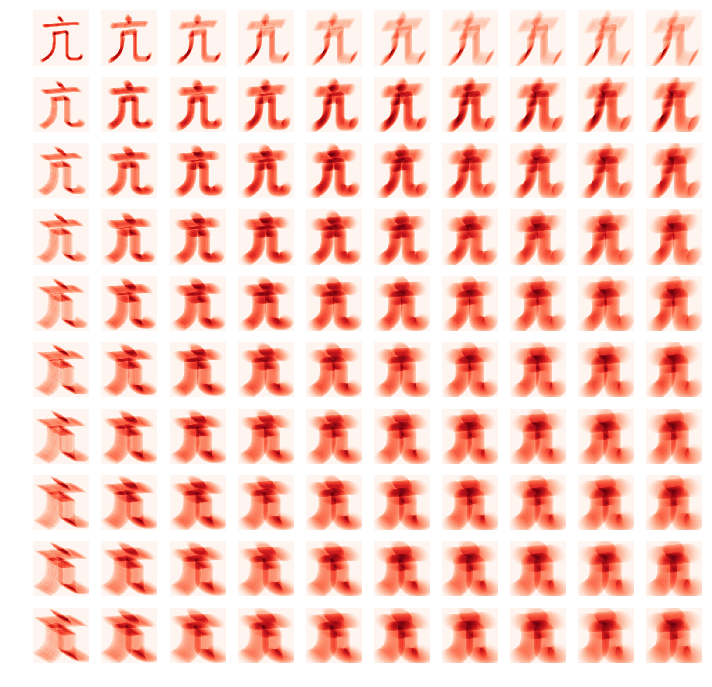

In [131]:
fig, ax = plt.subplots(param_dims[0], param_dims[1], figsize=(12, 12))
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        pattern  = make_ellipse(n, angle, a_s[i], b_s[j])
        drawing = fftconvolve(rastered, pattern, mode='same')
        ax[i, j].imshow(drawing, cmap='Reds', origin='lower')
        ax[i, j].axis('off')

We can do the same thing with a threshold.

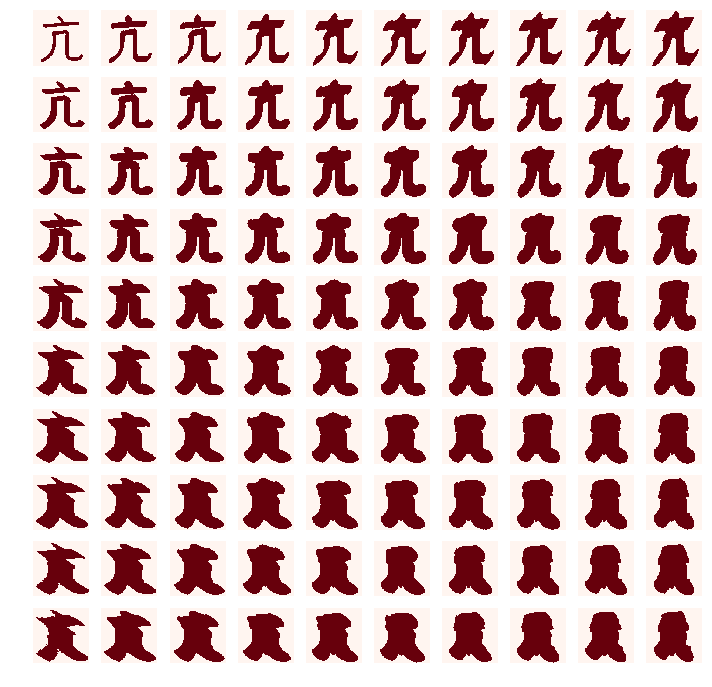

In [132]:
fig, ax = plt.subplots(param_dims[0], param_dims[1], figsize=(12, 12))
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        pattern  = make_ellipse(n, angle, a_s[i], b_s[j])
        drawing = fftconvolve(rastered, pattern, mode='same')
        ax[i, j].imshow(drawing > threshold_otsu(drawing), cmap='Reds', origin='lower')
        ax[i, j].axis('off')

We can also explore the angle parameter.

In [133]:
angles = np.linspace(-90, 90, num=param_dims[0])

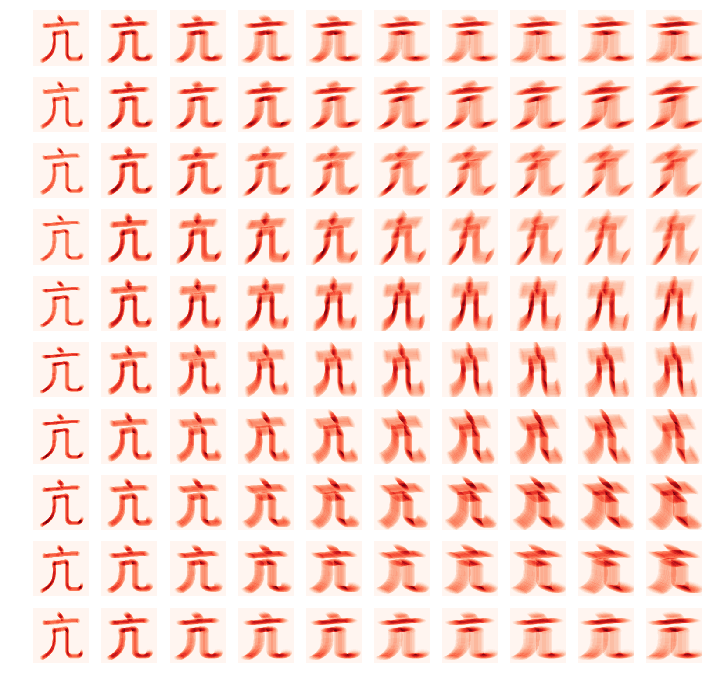

In [134]:
fig, ax = plt.subplots(10, 10, figsize=(12, 12))
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        pattern  = make_ellipse(n, angles[i], 0.2, b_s[j])
        drawing = fftconvolve(rastered, pattern, mode='same')
        ax[i, j].imshow(drawing, cmap='Reds', origin='lower')
        ax[i, j].axis('off')


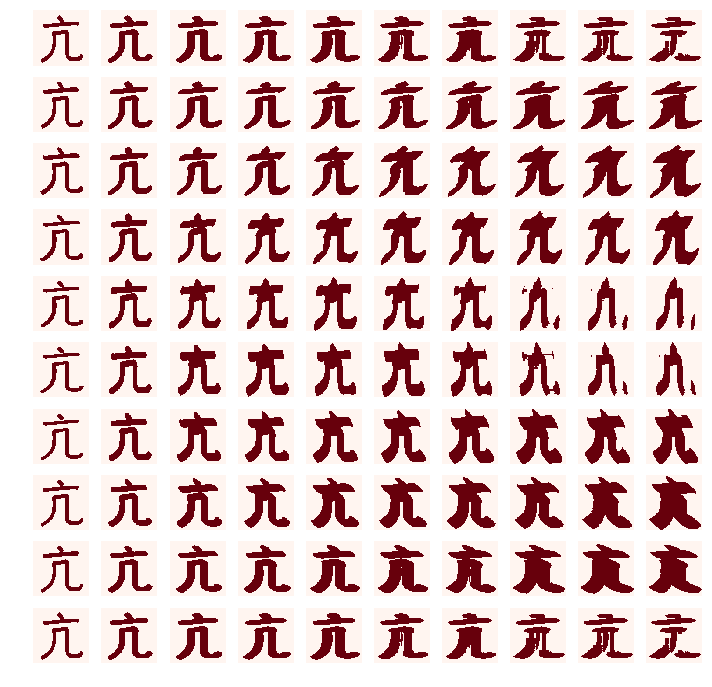

In [135]:
fig, ax = plt.subplots(10, 10, figsize=(12, 12))
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        pattern  = make_ellipse(n, angles[i], 0.2, b_s[j])
        drawing = fftconvolve(rastered, pattern, mode='same')
        ax[i, j].imshow(drawing > threshold_otsu(drawing), cmap='Reds', origin='lower')
        ax[i, j].axis('off')

## Extending to more characters 

We can easily fetch more characters to display on the KanjiVG website, imitating the mechanism inside their [javascript](http://kanjivg.tagaini.net/listing.html).

First request to get the sha:

In [136]:
r = requests.get("https://api.github.com/repos/KanjiVG/kanjivg/git/refs/heads/master")
sha = r.json()['object']['sha']

Second request: from the SHA we get the repo content.

In [137]:
r = requests.get("https://api.github.com/repos/KanjiVG/kanjivg/git/trees/" + sha)
r

<Response [200]>

In [138]:
for item in r.json()['tree']:
    if item['path'] == 'kanji':
        print(item)
        break

{'sha': '1d160f49915b3f573639347124a5c108e25de5fd', 'path': 'kanji', 'url': 'https://api.github.com/repos/KanjiVG/kanjivg/git/trees/1d160f49915b3f573639347124a5c108e25de5fd', 'mode': '040000', 'type': 'tree'}


Third request to acutally fetch all kanji files in the repo.

In [139]:
r = requests.get(item['url'])
r

<Response [200]>

This request allows us to find the urls and filenames of all kanjis. For instance the first one.

In [140]:
tree = r.json()['tree']

In [141]:
tree[0]

{'mode': '100644',
 'path': '00021.svg',
 'sha': 'ef913b00bedc63bc7cb4b50f0783bfd417c02693',
 'size': 1944,
 'type': 'blob',
 'url': 'https://api.github.com/repos/KanjiVG/kanjivg/git/blobs/ef913b00bedc63bc7cb4b50f0783bfd417c02693'}

In [142]:
url = tree[1020]['url']

In [143]:
r = requests.get(url)
r

<Response [200]>

In [144]:
content = r.json()['content']

The content is base64 encoded so we need to decode it.

In [145]:
import base64

In [146]:
decoded_content = base64.b64decode(content).decode('utf-8')
decoded_content

'<?xml version="1.0" encoding="UTF-8"?>\n<!--\nCopyright (C) 2009/2010/2011 Ulrich Apel.\nThis work is distributed under the conditions of the Creative Commons\nAttribution-Share Alike 3.0 Licence. This means you are free:\n* to Share - to copy, distribute and transmit the work\n* to Remix - to adapt the work\n\nUnder the following conditions:\n* Attribution. You must attribute the work by stating your use of KanjiVG in\n  your own copyright header and linking to KanjiVG\'s website\n  (http://kanjivg.tagaini.net)\n* Share Alike. If you alter, transform, or build upon this work, you may\n  distribute the resulting work only under the same or similar license to this\n  one.\n\nSee http://creativecommons.org/licenses/by-sa/3.0/ for more details.\n-->\n<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.0//EN" "http://www.w3.org/TR/2001/REC-SVG-20010904/DTD/svg10.dtd" [\n<!ATTLIST g\nxmlns:kvg CDATA #FIXED "http://kanjivg.tagaini.net"\nkvg:element CDATA #IMPLIED\nkvg:variant CDATA #IMPLIED\nkvg:partia

Finally, we can use this.

In [147]:
decoded_content

'<?xml version="1.0" encoding="UTF-8"?>\n<!--\nCopyright (C) 2009/2010/2011 Ulrich Apel.\nThis work is distributed under the conditions of the Creative Commons\nAttribution-Share Alike 3.0 Licence. This means you are free:\n* to Share - to copy, distribute and transmit the work\n* to Remix - to adapt the work\n\nUnder the following conditions:\n* Attribution. You must attribute the work by stating your use of KanjiVG in\n  your own copyright header and linking to KanjiVG\'s website\n  (http://kanjivg.tagaini.net)\n* Share Alike. If you alter, transform, or build upon this work, you may\n  distribute the resulting work only under the same or similar license to this\n  one.\n\nSee http://creativecommons.org/licenses/by-sa/3.0/ for more details.\n-->\n<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.0//EN" "http://www.w3.org/TR/2001/REC-SVG-20010904/DTD/svg10.dtd" [\n<!ATTLIST g\nxmlns:kvg CDATA #FIXED "http://kanjivg.tagaini.net"\nkvg:element CDATA #IMPLIED\nkvg:variant CDATA #IMPLIED\nkvg:partia

Let's write a function that does all the heavy lifting above.

In [162]:
r.status_code

200

In [163]:
def get_decoded_svg(index):
    "Returns decoded SVG from internet."
    url = tree[index]['url']
    r = requests.get(url)
    if r.status_code == 200:
        content = r.json()['content']
        return base64.b64decode(content).decode('utf-8')
    else:
        return None

In [166]:
decoded_content = get_decoded_svg(1020)

In [165]:
SVG(data=decoded_content)

<IPython.core.display.SVG object>

In [151]:
paths = extract_paths_from_svg(decoded_content)

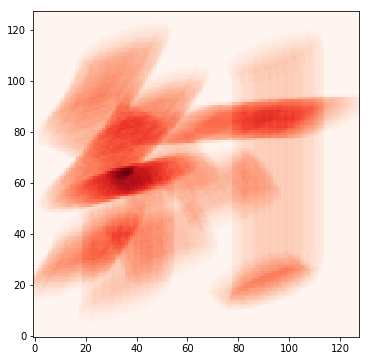

In [167]:
plt.figure(figsize=(6, 6))
all_curves = []
for path in paths:
    path_data = path.items()[2][1]
    curves = parse_path(path_data)
    all_curves.extend(curves)
rastered = rasterize(all_curves)
drawing = fftconvolve(rastered, pattern, mode='same')
plt.imshow(drawing, origin='lower', cmap='Reds')

Let's now build a random gallery using random strokes.

In [168]:
len(tree)

11456

In [169]:
ax.size

100

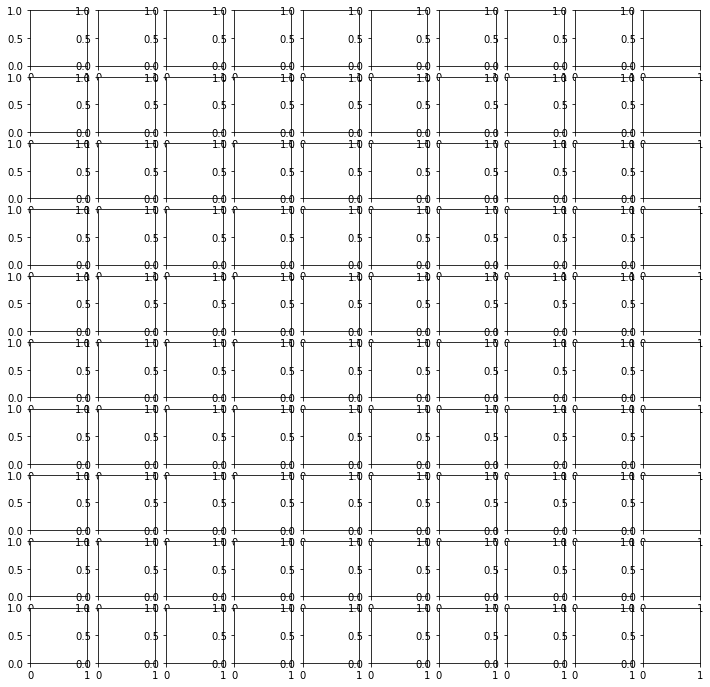

In [171]:
fig, ax = plt.subplots(10, 10, figsize=(12, 12))
indexes = np.random.choice(np.arange(len(tree)), size=ax.size, replace=False)
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        decoded_content = get_decoded_svg(indexes.reshape(ax.shape)[i, j])
        if decoded_content is not None:
            paths = extract_paths_from_svg(decoded_content)
            all_curves = []
            for path in paths:
                path_data = path.items()[2][1]
                curves = parse_path(path_data)
                all_curves.extend(curves)
            rastered = rasterize(all_curves)
            pattern  = make_ellipse(n, angles[i], 0.2, b_s[j])
            drawing = fftconvolve(rastered, pattern, mode='same')
            ax[i, j].imshow(drawing > threshold_otsu(drawing), cmap='Reds', origin='lower')
            ax[i, j].axis('off')

There is a bug that will prevent the construction of different types of characters... since I was too lazy to parse all the data.